### This notebook evaluates precipitation efficiency for MCSs in the idealized RCE simulations.

In [1]:
import numpy as np
import scipy as sp
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings, random
from matplotlib import cm
import scipy.optimize
from random import randint

from scipy.optimize import curve_fit

plt.rcParams.update({'font.size': 12})

warnings.filterwarnings(action='ignore')

from plotting_utilities import *
from thermodynamic_functions import *

# blue-to-red colormap
BR_color_cycle = ["navy", "blue", "lightskyblue", "tomato", "red", "darkred"]

In [2]:
# parameters needed in this script
eps = 0.01802/0.02897 # ratio of MW_water to MW_air
g = 9.8 # gravity [m s-2]
rho_w = 997 # density of water [kg m-3]
R_air = 287.058 # [J kg-1 K-1]

### Loading RCE data and precipitation efficiency calculation

In [34]:
path = '/groups/sylvia/JAS-MCS-rain/RCE-postprocessed/all-var-percentile/'
ssts = np.arange( 290, 315, 5 )
mean_RCE, p99_RCE, rad = read_RCE_files( path )
rad_RCE = np.concatenate( [r for r in rad], axis=0 )
altitudes = mean_RCE[0]['z']

In [35]:
peff_list = [ [] for i in np.arange( len(mean_RCE) ) ]
rad_RCE_sub = [ [] for i in np.arange( len(mean_RCE) ) ]

# Calculate the gradient with respect to pressure of the saturation vapor mixing ratio
for iterator, array in enumerate( mean_RCE ):
    precip_RCE = array['p_rate']
    T_RCE = array['TABS']
    p_RCE = array['p'] * 100. # converting hPa -> Pa
    z_RCE = array['z']
    qvsat_RCE = eps * satVapP_liq(T_RCE) / ( p_RCE - satVapP_liq(T_RCE) )
    RH = array['QV'] / (qvsat_RCE * 1000.) # factor of 1000. to put both in [g kg-1]

    # Then calculate the gradient versus altitude in that saturation vapor mixing ratio
    dqvsat_dz_RCE = qvsat_RCE.differentiate( 'z' )
    
    # Determine the lifting condensation level, Tdew from the Magnus formula
    Tsfc_mean = T_RCE[:,0].mean( dim={'clusters'} )
    RHsfc_mean = RH[:,0].mean( dim={'clusters'} )
    Tdew_mean = dew_point_temperature( Tsfc_mean, RHsfc_mean )
    LCL = (Tsfc_mean - Tdew_mean).values/8*1000.
    k = np.abs( LCL - z_RCE ).argmin( 'z' ).values

    # Determine the cold-point tropopause,
    # i.e. where the temperature change becomes negative as the stratosphere warms
    Tmean = T_RCE.mean( dim={'clusters'} )
    j = np.argwhere( (Tmean[:-1].values - Tmean[1:].values) < 0 )[0,0]
    
    # Convert pressure velocity to vertical velocity
    rho_air = p_RCE / (R_air * T_RCE) # [kg m-3]
    w_RCE = -1.*array['omega'] / rho_air / g # [m s-1]
    w_RCE = xr.where( w_RCE>0, w_RCE, 0. )
    
    # Multiply the gradient with respect to altitude by vertical velocity
    #integrand = w_RCE[ii] * dqvsat_dz_RCE[ii] * rho_air
    integrand = w_RCE * dqvsat_dz_RCE * rho_air
    
    # Integrate the condensation rate over the altitudes
    cond_rate_RCE = integrand[:,k+1:j-1].integrate( coord='z' )  #[:,k+1:j-1]
    peff_RCE = -1.*precip_RCE / 3600 / cond_rate_RCE  # index 0 for p_RCE is the surface
    zscore = ( peff_RCE - np.nanmean(peff_RCE) )/np.nanstd(peff_RCE)
    peff_list[iterator] = peff_RCE[zscore <= 2]
    rad_RCE_sub[iterator] = [ r for r, z in zip(rad[iterator], zscore) if z <= 2]
    print( np.nanstd(peff_RCE), np.nanmin(peff_RCE), np.nanmedian(peff_RCE), np.nanmean(peff_RCE), np.nanpercentile(peff_RCE,90) )
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

0.3752573932866285 0.0 0.7012216873641439 0.6500816913915116 1.0791099635597
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.3887963863335865 0.0 0.6229163348106798 0.5558507335152524 0.9922922527387258
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.37524174373762353 0.0 0.5151469552061461 0.4564352670257868 0.887113349842904
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.34317528199623143 0.0 0.35988882025738106 0.35338875042936074 0.7460753911631597
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.32423107496937215 0.0 0.3359415410379488 0.32673744732475635 0.6792363528121601
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [36]:
# Filter for size
loo = np.percentile( rad_RCE, 25 )
upp = np.percentile( rad_RCE, 75 )
all_precipeff = np.concatenate( [p for p in peff_list] )
rad_RCE_subarray = np.concatenate( [ r for r in rad_RCE_sub ] )
precip_eff_small = all_precipeff[ rad_RCE_subarray <= loo ]
precip_eff_large = all_precipeff[ rad_RCE_subarray >= upp ]
print( np.nanmin(all_precipeff), np.nanmedian(all_precipeff), np.nanmean(all_precipeff), np.nanpercentile(all_precipeff,90) )
print( np.nanmin(precip_eff_small), np.nanmedian(precip_eff_small), np.nanmean(precip_eff_small), np.nanpercentile(precip_eff_small,90) )
print( np.nanmin(precip_eff_large), np.nanmedian(precip_eff_large), np.nanmean(precip_eff_large), np.nanpercentile(precip_eff_large,90) )

0.0 0.43970883476668815 0.42357705903249326 0.8834520708845929
0.0 0.4006574525645765 0.4125208782364646 0.896001105340932
0.0 0.42812727885158075 0.4016901604267583 0.7951327911370363


### Load in condensate amounts and calculate CWP

In [37]:
# across various SSTs
cwp_list = [ [] for i in np.arange( len(mean_RCE) ) ]
qc_list = [ [] for i in np.arange( len(mean_RCE) ) ]
for iterator, array in enumerate( mean_RCE ):
    T_RCE = array['TABS']
    p_RCE = array['p'] * 100. # converting hPa -> Pa
    altitudes = array['z']
    rho_air = p_RCE / (R_air * T_RCE) # [kg m-3]
    condensate_RCE = array['QN'] / 1000 # [kg kg-1] (from [g kg-1])
    cwp_list[iterator] = np.trapz( condensate_RCE * rho_air, altitudes )*1000 # [g m-2]
    qc_list[iterator] = np.nanmedian( array['QN'], axis=0 )

In [39]:
# across all SSTs and stratifying for extent
condensate_RCE = RCE_concat( mean_RCE, 'QN' )/1000 # [kg kg-1] (from [g kg-1])
T_RCE_all = RCE_concat( mean_RCE, 'TABS' )
p_RCE_all = RCE_concat( mean_RCE, 'p' )*100 # [Pa] (from [hPa])
rho_air = p_RCE_all / (R_air * T_RCE_all) # [kg m-3]

CWP_RCE = np.zeros( (condensate_RCE.shape[0],) )
for i in np.arange(condensate_RCE.shape[0]):
    j = np.argwhere( ~np.isnan(condensate_RCE[i]) )
    start = j[0][0]
    end = j[-1][0]
    CWP_RCE[i] = np.trapz( condensate_RCE[i,start:end] * rho_air[i,start:end], altitudes[start:end] )*1000 # [g m-2]

CWP_small = CWP_RCE[ rad_RCE <= loo ]
CWP_large = CWP_RCE[ rad_RCE >= upp ]

condensate_RCE_med = np.nanmedian( condensate_RCE, axis=0 )*1000. # convert back to [g kg-1] here
condensate_RCE_p99 = np.nanpercentile( condensate_RCE, 90, axis=0 )*1000.
condensate_large = np.nanmedian( condensate_RCE[rad_RCE >= upp], axis=0 )*1000. # convert back to [g kg-1] here
condensate_large_p99 = np.nanpercentile( condensate_RCE[rad_RCE >= upp], 90, axis=0 )*1000.
condensate_small = np.nanmedian( condensate_RCE[rad_RCE <= loo], axis=0 )*1000. # convert back to [g kg-1] here
condensate_small_p99 = np.percentile( condensate_RCE[rad_RCE <= loo], 90, axis=0 )*1000.

### Plot the precipitation efficiency and condensate PDFs

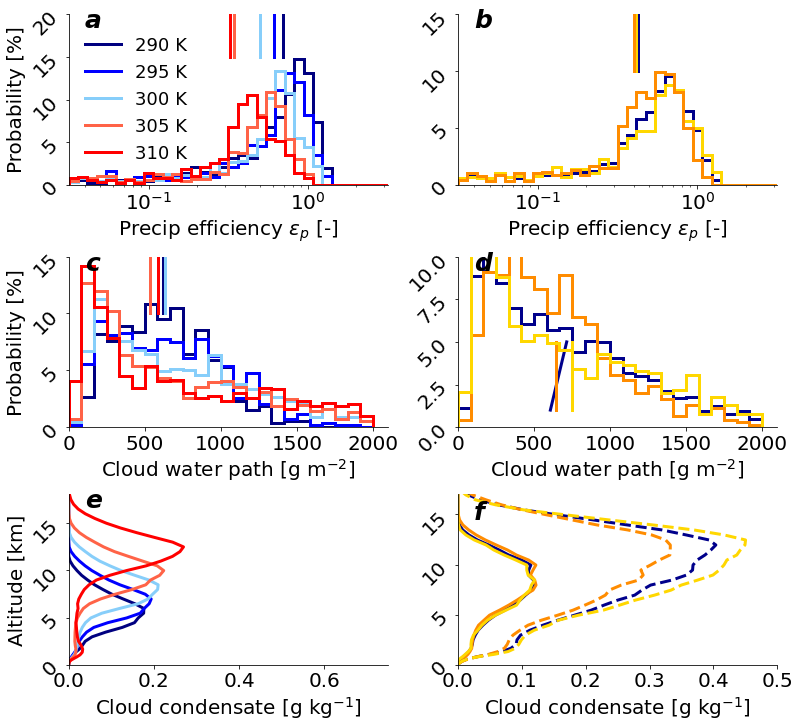

In [45]:
lower = -1.5
upper = 0.5
lower2 = 0
upper2 = 2000
nbin = 35
nbin2 = 25
fs = 20
xlab = [ r'Precip efficiency $\varepsilon_p$ [-]', r'Precip efficiency $\varepsilon_p$ [-]', 
         r'Cloud water path [g m$^{-2}$]', r'Cloud water path [g m$^{-2}$]',
         r'Cloud condensate [g kg$^{-1}$]', r'Cloud condensate [g kg$^{-1}$]' ]
fig, ax = plt.subplots( 3, 2, figsize =(11, 10), constrained_layout=True )

for i, j, k, l in zip( peff_list, cwp_list, qc_list, np.arange(len(peff_list)) ):
    wgts = np.ones_like( i )/float( len( i ) )*100.
    ax[0,0].hist( i, bins=np.logspace(lower, upper, nbin), histtype='step', weights=wgts, linewidth=3,
               edgecolor=BR_color_cycle[l] )
    ax[0,0].plot( [np.nanmedian(i), np.nanmedian(i)], [15, 20], linewidth=3, ls='-',
               color=BR_color_cycle[l], label=str(ssts[l])+' K' )
    wgts = np.ones_like( j )/float( len( j ) )*100.
    ax[1,0].hist( j, bins=np.linspace(lower2, upper2, nbin2), histtype='step', weights=wgts, linewidth=3,
               edgecolor=BR_color_cycle[l] )
    ax[1,0].plot( [np.nanmedian(j), np.nanmedian(j)], [10, 15], linewidth=3, ls='-',
               color=BR_color_cycle[l], label=str(ssts[l])+' K' )
    ax[2,0].plot( k, altitudes/1000., linewidth=3, color=BR_color_cycle[l] )
    
ax[0,0].legend( frameon=False, loc='center left', fontsize=fs-2 )
ax[0,0].set_ylim( [0, 20] )
ax[1,0].set_ylim( [0, 15] )
ax[2,0].set_ylim( [0, 18] )
ax[0,0].set_ylabel( 'Probability [%]', fontsize=fs )
ax[1,0].set_ylabel( 'Probability [%]', fontsize=fs )
ax[2,0].set_ylabel( 'Altitude [km]', fontsize=fs )

all_precipeff = np.concatenate( (peff_list[0], peff_list[1], peff_list[2], peff_list[3], peff_list[4]) )
wgts = np.ones_like( all_precipeff )/float( len( all_precipeff ) )*100.
ax[0,1].hist( all_precipeff, bins=np.logspace(lower, upper, nbin), histtype='step', weights=wgts, linewidth=3, edgecolor='darkblue' )
ax[0,1].plot( [np.nanmean(all_precipeff), np.nanmean(all_precipeff)], [10, 15], ls='-', linewidth=3, color='darkblue' )

wgts = np.ones_like( precip_eff_small )/float( len( precip_eff_small ) )*100.
ax[0,1].hist( precip_eff_small, bins=np.logspace(lower, upper, nbin), histtype='step', weights=wgts, linewidth=3, edgecolor='gold' )
ax[0,1].plot( [np.nanmean(precip_eff_small), np.nanmean(precip_eff_small)], [10, 15], ls='-', linewidth=3, color='gold' )

wgts = np.ones_like( precip_eff_large )/float( len( precip_eff_large ) )*100.
ax[0,1].hist( precip_eff_large, bins=np.logspace(lower, upper, nbin), histtype='step', weights=wgts, linewidth=3, edgecolor='darkorange' )
ax[0,1].plot( [np.nanmean(precip_eff_large), np.nanmean(precip_eff_large)], [10, 15], ls='-', linewidth=3, color='darkorange' )
ax[0,1].set_ylim( [0, 15] )

wgts = np.ones_like( CWP_RCE )/float( len( CWP_RCE ) )*100.
ax[1,1].hist( CWP_RCE, bins=np.linspace(lower2, upper2, nbin2), histtype='step', weights=wgts, linewidth=3, edgecolor='darkblue' )
ax[1,1].plot( [np.nanmedian(CWP_RCE), np.nanmean(CWP_RCE)], [1, 5], ls='-', linewidth=3, color='darkblue' )

wgts = np.ones_like( CWP_large )/float( len( CWP_large ) )*100.
ax[1,1].hist( CWP_large, bins=np.linspace(lower2, upper2, nbin2), histtype='step', weights=wgts, linewidth=3, edgecolor='darkorange' )
ax[1,1].plot( [np.nanmean(CWP_large), np.nanmean(CWP_large)], [1, 5], ls='-', linewidth=3, color='darkorange' )

wgts = np.ones_like( CWP_small )/float( len( CWP_small ) )*100.
ax[1,1].hist( CWP_small, bins=np.linspace(lower2, upper2, nbin2), histtype='step', weights=wgts, linewidth=3, edgecolor='gold' )
ax[1,1].plot( [np.nanmean(CWP_small), np.nanmean(CWP_small)], [1, 5], ls='-', linewidth=3, color='gold' )
ax[1,1].set_ylim( [0, 10] )

ax[2,1].plot( condensate_RCE_med, altitudes/1000., linewidth=3, color='darkblue' )
ax[2,1].plot( condensate_large, altitudes/1000., linewidth=3, color='darkorange' )
ax[2,1].plot( condensate_small, altitudes/1000., linewidth=3, color='gold' )
ax[2,1].plot( condensate_RCE_p99, altitudes/1000., linewidth=3, ls='--', color='darkblue' )
ax[2,1].plot( condensate_large_p99, altitudes/1000., linewidth=3, ls='--', color='darkorange' )
ax[2,1].plot( condensate_small_p99, altitudes/1000., linewidth=3, ls='--', color='gold' )
ax[2,1].set_xlim( [0,0.5] )
ax[2,1].set_ylim( [0,17] )

let = [ 'a', 'b', 'c', 'd', 'e', 'f' ]
for i, a in enumerate(ax.flatten()):
    a.set_xlabel( xlab[i], fontsize=fs )
    a.tick_params( 'both', labelsize=fs )
    a.tick_params( 'y', rotation=45 )
    if i == 0 or i == 1:
        a.set_xlim( [10**(lower), 10**(upper)] )
        a.set_xscale( 'log' )
    if i == 2 or i == 3:
        a.set_xlim( [0, upper2+100] )
    if i == 4:
        a.set_xlim( [0, 0.75] )
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    if i != 5:
        a.text( 0.05, 0.92, let[i], style='italic', transform=a.transAxes, weight='bold', fontsize=fs+5 )
    else:
        a.text( 0.05, 0.85, let[i], style='italic', transform=a.transAxes, weight='bold', fontsize=fs+5 )

#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/precipeff-RCE.pdf', bbox_inches='tight' )
plt.show()

In [6]:
wgts = np.ones_like( all_precipeff )/float( len( all_precipeff ) )*100.
ax[1].hist( all_precipeff, bins=np.logspace(-1, 0, 35), histtype='step', weights=wgts, linewidth=3, edgecolor='darkblue' )
ax[1].plot( [np.nanmean(all_precipeff), np.nanmean(all_precipeff)], [9, 15], ls='-', linewidth=3, color='darkblue' )

loo = np.percentile( rad_RCE, 25 )
upp = np.percentile( rad_RCE, 75 )
precip_eff_small = all_precipeff[ rad_RCE <= loo ]
precip_eff_large = all_precipeff[ rad_RCE >= upp ]
wgts = np.ones_like( precip_eff_small )/float( len( precip_eff_small ) )*100.
ax[1].hist( precip_eff_small, bins=np.logspace(-1, 0, 35), histtype='step', weights=wgts, linewidth=3, edgecolor='gold' )
ax[1].plot( [np.nanmean(precip_eff_small), np.nanmean(precip_eff_small)], [9, 15], ls='-', linewidth=3, color='gold' )

wgts = np.ones_like( precip_eff_large )/float( len( precip_eff_large ) )*100.
ax[1].hist( precip_eff_large, bins=np.logspace(-1, 0, 35), histtype='step', weights=wgts, linewidth=3, edgecolor='darkorange' )
ax[1].plot( [np.nanmean(precip_eff_large), np.nanmean(precip_eff_large)], [9, 15], ls='-', linewidth=3, color='darkorange' )
#ax[1].set_ylim( [0, 12] )

let = [ 'a', 'b' ]
for i, a in enumerate(ax):
    a.set_xlabel( r'Precip efficiency $\varepsilon_p$ [-]', fontsize=fs )
    a.set_xscale( 'log' )
    a.tick_params( 'both', labelsize=fs )
    a.tick_params( 'y', rotation=45 )
    a.set_xlim( [-2, 0] )
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.text( 0.05, 0.92, let[i], style='italic', transform=a.transAxes, weight='bold', fontsize=fs+5 )

#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/precipeff-RCE.pdf', bbox_inches='tight' )
plt.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 522 but corresponding boolean dimension is 3634